In [1]:
import numpy as np
import botorch
import matplotlib as mpl
import math
import torch
import gpytorch
import blop

from matplotlib import pyplot as plt

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.optim import fit
from botorch.sampling import IIDNormalSampler
from tqdm import tqdm

from blop.bayesian.models import LatentDirichletClassifier

In [166]:
from blop.utils.functions import himmelblau

def function_with_constraints(x1, x2):

    f1 = np.exp(-1e-2 * himmelblau(x1, x2)).double()
    f2 = np.exp(-1e-2 * himmelblau(x2, x1)).double()
    c1 = x1 < 2
    c2 = x2 > -3

    return torch.stack((f1,f2), -1)  #f1, f2 #, c1, c2


bounds = torch.stack([torch.zeros(2), torch.ones(2)]).double()*10 - 5

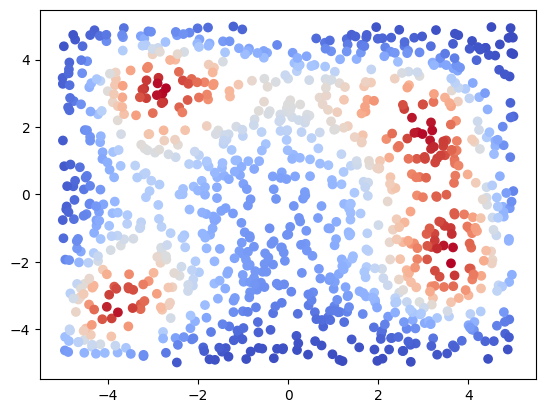

In [146]:
test_X = test_X = 10 * torch.rand(size=(1024, 1, 2)).double() - 5
plt.scatter(*test_X.squeeze().T, c=function_with_constraints(*test_X.T)[..., 0])

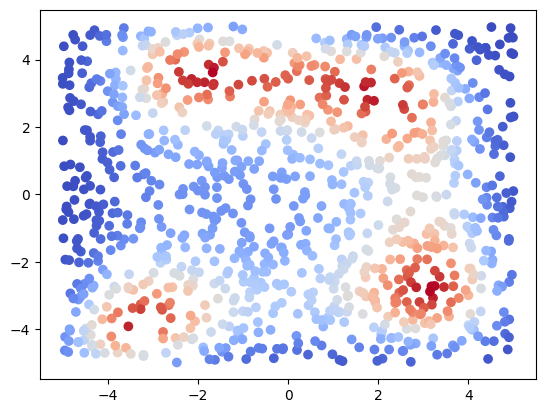

In [147]:
plt.scatter(*test_X.squeeze().T, c=function_with_constraints(*test_X.T)[..., 1])


In [148]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [149]:
from botorch.test_functions.multi_objective import BraninCurrin

problem = BraninCurrin(negate=True).to(**tkwargs)

In [167]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

#NOISE_SE = torch.tensor([15.19, 0.63], **tkwargs)


def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=bounds, n=n, q=1).squeeze(1)
    #train_obj_true = problem(train_x)
    train_obj_true = function_with_constraints(*train_x.T)
    train_obj = train_obj_true #+ torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    train_x = normalize(train_x, bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        #train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        models.append(
            SingleTaskGP(
                train_x, train_y, outcome_transform=Standardize(m=1)
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [168]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 4
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, 2, **tkwargs)
standard_bounds[1] = 1
# bounds = torch.stack([torch.zeros(2), torch.ones(2)])*10 - 5
# bounds = standard_bounds

In [169]:
ref_point = torch.tensor([0.5,0.5]).double()

def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point= ref_point.tolist(),  # use known reference point
        X_baseline=normalize(train_x, bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds, #I CHANGED THIS,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj_true = function_with_constraints(*new_x.T)
    new_obj = new_obj_true #+ torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

In [170]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 20 if not SMOKE_TEST else 5
MC_SAMPLES = 128 if not SMOKE_TEST else 16

verbose = True

hvs_qnehvi= []

# call helper functions to generate initial training data and initialize model

train_x_qnehvi, train_obj_qnehvi, train_obj_true_qnehvi = generate_initial_data(
    n=6
)

mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)

# compute hypervolume
bd = DominatedPartitioning(ref_point=ref_point, Y=train_obj_true_qnehvi)
volume = bd.compute_hypervolume().item()

hvs_qnehvi.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):

    t0 = time.monotonic()

    # fit the models
    fit_gpytorch_mll(mll_qnehvi)

    # define the qEI and qNEI acquisition modules using a QMC sampler
    qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition functions and get new observations
    (
        new_x_qnehvi,
        new_obj_qnehvi,
        new_obj_true_qnehvi,
    ) = optimize_qnehvi_and_get_observation(
        model_qnehvi, train_x_qnehvi, train_obj_qnehvi, qnehvi_sampler
    )

    # update training points

    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
    train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
    train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj_true_qnehvi])

    # update progress
    for hvs_list, train_obj in zip(
        (hvs_qnehvi,),
        (
            train_obj_true_qnehvi,
        ),
    ):
        # compute hypervolume
        bd = DominatedPartitioning(ref_point=ref_point, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)

    t1 = time.monotonic()

    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume qNEHVI = "
             f"({hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")


Batch  1: Hypervolume qNEHVI = (0.07), time = 14.98.
Batch  2: Hypervolume qNEHVI = (0.16), time = 18.44.
Batch  3: Hypervolume qNEHVI = (0.22), time = 27.64.
Batch  4: Hypervolume qNEHVI = (0.23), time = 20.25.
Batch  5: Hypervolume qNEHVI = (0.23), time = 23.00.
Batch  6: Hypervolume qNEHVI = (0.23), time = 19.19.
Batch  7: Hypervolume qNEHVI = (0.23), time = 25.61.
Batch  8: Hypervolume qNEHVI = (0.23), time = 19.98.
Batch  9: Hypervolume qNEHVI = (0.23), time = 22.55.
Batch 10: Hypervolume qNEHVI = (0.23), time = 23.69.
Batch 11: Hypervolume qNEHVI = (0.23), time = 25.12.
Batch 12: Hypervolume qNEHVI = (0.23), time = 28.52.
Batch 13: Hypervolume qNEHVI = (0.23), time = 32.53.
Batch 14: Hypervolume qNEHVI = (0.23), time = 32.77.
Batch 15: Hypervolume qNEHVI = (0.23), time = 31.38.
Batch 16: Hypervolume qNEHVI = (0.23), time = 25.75.
Batch 17: Hypervolume qNEHVI = (0.23), time = 34.38.
Batch 18: Hypervolume qNEHVI = (0.23), time = 36.44.
Batch 19: Hypervolume qNEHVI = (0.23), time =

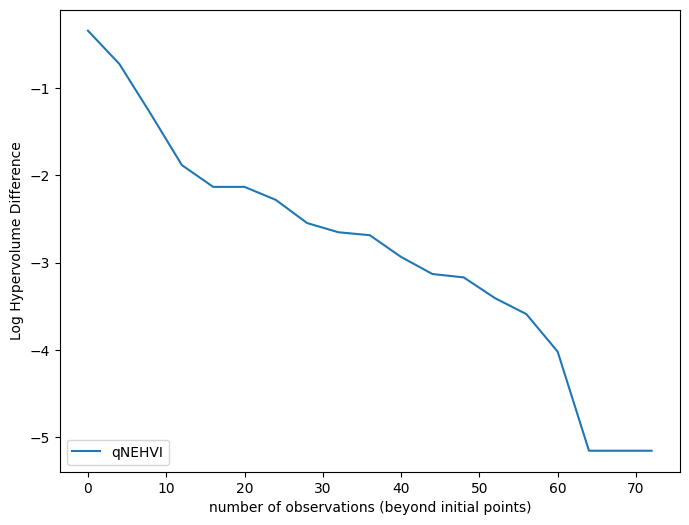

In [154]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qnehvi = np.log10(max(hvs_qnehvi) - np.asarray(hvs_qnehvi))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters,
    log_hv_difference_qnehvi,
    label="qNEHVI",
    linewidth=1.5,
)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="Log Hypervolume Difference",
)
ax.legend(loc="lower left")

Text(0.5, 1.0, 'Iteration')

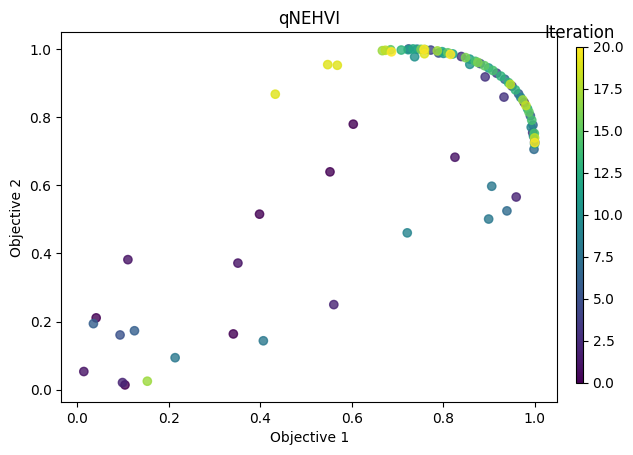

In [172]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots()
cm = plt.get_cmap("viridis")

batch_number = torch.cat(
    [
        torch.zeros(2 * (2 + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()
train_obj=train_obj_true_qnehvi
sc = ax.scatter(
    train_obj[:, 0].cpu().numpy(),
    train_obj[:, 1].cpu().numpy(),
    c=batch_number,
    alpha=0.8,
    cmap = cm
)
ax.set_title("qNEHVI")
ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

In [58]:
# NOW TRYING WITH CONSTRAINTS

In [202]:
def function_with_constraints(x1, x2):

    f1 = np.exp(-1e-2 * himmelblau(x1, x2)).double()
    f2 = np.exp(-1e-2 * himmelblau(x2, x1)).double()
    c1 = x1 - 2
    c2 = -3 - x2

    return torch.stack((f1,f2, c1, c2), -1)  #f1, f2 #, c1, c2


bounds = torch.stack([torch.zeros(2), torch.ones(2)]).double()*10 - 5

In [203]:
def generate_initial_data(n):
    # generate training data
    train_x = draw_sobol_samples(bounds=bounds, n=n, q=1).squeeze(1)
    train_obj = function_with_constraints(*train_x.T)[:, 0:2]
    # negative values imply feasibility in botorch
    train_con = function_with_constraints(*train_x.T)[:, 2:]
    return train_x, train_obj, train_con


def initialize_model(train_x, train_obj, train_con):
    # define models for objective and constraint
    train_x = normalize(train_x, bounds)
    train_y = torch.cat([train_obj, train_con], dim=-1)
    models = []
    for i in range(train_y.shape[-1]):
        models.append(
            SingleTaskGP(
                train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [211]:
from botorch.acquisition.multi_objective.monte_carlo import (
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

ref_point = torch.tensor([0.5,0.5]).double()
standard_bounds = torch.zeros(2, 2, **tkwargs)
standard_bounds[1] = 1

def optimize_qnehvi_and_get_observation(model, train_x, train_obj, train_con, sampler):
    """Optimizes the qNEHVI acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, bounds)
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),  # use known reference point
        X_baseline=train_x,
        sampler=sampler,
        prune_baseline=True,
        # define an objective that specifies which outcomes are the objectives
        objective=IdentityMCMultiOutputObjective(outcomes=[0, 1]),
        # specify that the constraint is on the last outcome
        constraints=[lambda Z: Z[..., -1]],
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = function_with_constraints(*new_x.T)[:, 0:2]
    # negative values imply feasibility in botorch
    new_con = function_with_constraints(*new_x.T)[:, 2:]
    return new_x, new_obj, new_con

In [212]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.pareto import is_non_dominated


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 20 if not SMOKE_TEST else 5
MC_SAMPLES = 128 if not SMOKE_TEST else 16
verbose = True

hv = Hypervolume(ref_point=ref_point)
hvs_qnehvi = []

# call helper functions to generate initial training data and initialize model
train_x_qnehvi, train_obj_qnehvi, train_con_qnehvi = generate_initial_data(
    n=2 * (2 + 1)
)

mll_qnehvi, model_qnehvi = initialize_model(
    train_x_qnehvi, train_obj_qnehvi, train_con_qnehvi
)

# compute pareto front
is_feas = (train_con_qnehvi <= 0).all(dim=-1)

feas_train_obj = train_obj_qnehvi[is_feas]
if feas_train_obj.shape[0] > 0:
    pareto_mask = is_non_dominated(feas_train_obj)
    pareto_y = feas_train_obj[pareto_mask]
    # compute hypervolume
    volume = hv.compute(pareto_y)
else:
    volume = 0.0

hvs_qnehvi.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):
    t0 = time.monotonic()

    # fit the models
    fit_gpytorch_mll(mll_qnehvi)

    # define the qParEGO and qNEHVI acquisition modules using a QMC sampler
    qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition functions and get new observations
    new_x_qnehvi, new_obj_qnehvi, new_con_qnehvi = optimize_qnehvi_and_get_observation(
        model_qnehvi, train_x_qnehvi, train_obj_qnehvi, train_con_qnehvi, qnehvi_sampler
    )

    # update training points

    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
    train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
    train_con_qnehvi = torch.cat([train_con_qnehvi, new_con_qnehvi])

    # update progress
    # compute pareto front
    is_feas = (train_con_qnehvi <= 0).all(dim=-1)
    
    feas_train_obj = train_obj_qnehvi[is_feas]
    if feas_train_obj.shape[0] > 0:
        pareto_mask = is_non_dominated(feas_train_obj)
        pareto_y = feas_train_obj[pareto_mask]
        # compute feasible hypervolume
        volume = hv.compute(pareto_y)
    else:
        volume = 0.0
    hvs_qnehvi.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration

    mll_qnehvi, model_qnehvi = initialize_model(
        train_x_qnehvi, train_obj_qnehvi, train_con_qnehvi
    )

    t1 = time.monotonic()

    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (qNEHVI) = "
            f"({hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")


Batch  1: Hypervolume (qNEHVI) = (0.00), time = 7.58.
Batch  2: Hypervolume (qNEHVI) = (0.05), time = 22.12.
Batch  3: Hypervolume (qNEHVI) = (0.05), time = 13.25.
Batch  4: Hypervolume (qNEHVI) = (0.05), time = 18.64.
Batch  5: Hypervolume (qNEHVI) = (0.05), time = 13.11.
Batch  6: Hypervolume (qNEHVI) = (0.05), time = 10.14.
Batch  7: Hypervolume (qNEHVI) = (0.05), time = 10.12.
Batch  8: Hypervolume (qNEHVI) = (0.05), time = 20.83.
Batch  9: Hypervolume (qNEHVI) = (0.05), time = 11.62.
Batch 10: Hypervolume (qNEHVI) = (0.05), time = 11.23.
Batch 11: Hypervolume (qNEHVI) = (0.05), time = 15.42.
Batch 12: Hypervolume (qNEHVI) = (0.05), time = 13.78.
Batch 13: Hypervolume (qNEHVI) = (0.05), time = 16.27.
Batch 14: Hypervolume (qNEHVI) = (0.05), time = 12.20.
Batch 15: Hypervolume (qNEHVI) = (0.05), time = 15.53.
Batch 16: Hypervolume (qNEHVI) = (0.11), time = 14.02.
Batch 17: Hypervolume (qNEHVI) = (0.11), time = 14.67.
Batch 18: Hypervolume (qNEHVI) = (0.11), time = 16.52.
Batch 19: 

Text(0.5, 1.0, 'Iteration')

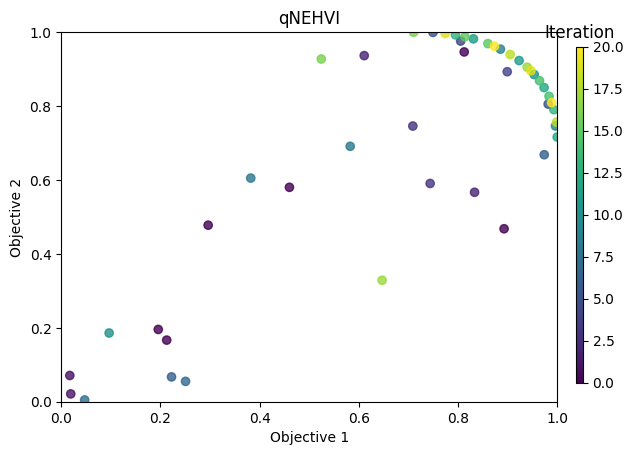

In [213]:
from matplotlib.cm import ScalarMappable
import matplotlib


fig, ax = plt.subplots()
algos = ["qNEHVI"]
cm = plt.get_cmap("viridis")

batch_number = torch.cat(
    [
        torch.zeros(2 * (2 + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()


sc = ax.scatter(
    train_obj_qnehvi[:, 0].cpu().numpy(),
    train_obj_qnehvi[:, 1].cpu().numpy(),
    c=batch_number,
    alpha=0.8,
    cmap = cm
)
ax.set_title(algos[0])
ax.set_xlabel("Objective 1")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

In [179]:
train_x_qnehvi

tensor([[ 4.6859,  3.1750],
        [-0.1386, -1.2374],
        [-3.2252,  1.7727],
        [ 1.5200, -3.8884],
        [ 0.9736,  1.1631],
        [-4.2415, -3.2489],
        [-5.0000, -2.6164],
        [-5.0000, -1.1669],
        [-0.1240,  3.3429],
        [-5.0000,  3.7704],
        [-0.5694,  4.5308],
        [-1.1625,  2.8140],
        [-0.8129,  2.1716],
        [-0.1071,  2.6820],
        [-0.9897,  3.1031],
        [-1.7489,  2.7043],
        [-1.9848,  3.1280],
        [-1.5740,  3.1998],
        [-2.4158,  3.3296],
        [-1.8773,  3.4191],
        [-2.6795,  3.1848],
        [-2.4136, -2.8029],
        [-2.2340,  3.4395],
        [-1.8913,  3.5678],
        [ 5.0000, -1.1442],
        [-2.5587,  3.2801],
        [-2.8118,  3.1236],
        [-2.3412,  3.3972],
        [-2.1251,  3.4879],
        [-2.4971,  3.3164],
        [-2.6222,  3.2413],
        [-2.8819,  3.2623],
        [-2.0197,  3.5189],
        [-2.3745,  3.3595],
        [-1.7874,  3.5893],
        [-2.2771,  3